In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#Import Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
#Initialization with 20 Epochs and 32 Batches and set images' path

initLayer = 1e-4
epochs = 20
batch = 32

In [ ]:
#SettingUp Image Data

directory = "/content/drive/MyDrive/FMDSAZ2/Code/dataset"
# categories = ["withMaskDataset","WithoutMask"]
categories = ["withoutMask","withMask"]
data = []
labels = []
for category in categories:
    path = os.path.join(directory, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#Encode Data and Labels

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
data = np.array(data,dtype="float32")
labels = np.array(labels)

In [ ]:
#Set 80% of Images for training and 20% for testing

(trainX,testX,trainY,testY) = train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=20)


In [ ]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
#Load MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
#Construct the head module
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
# Pace the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
#Loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False


In [ ]:
#Compile the neural network Module

opt = Adam(learning_rate=initLayer, decay=initLayer / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [ ]:
#Train the head of the module
H = model.fit(aug.flow(trainX, trainY, batch_size=batch),
    steps_per_epoch=len(trainX) // batch,
    validation_data=(testX, testY),
    validation_steps=len(testX) // batch,
    epochs=epochs)

Epoch 1/20
95/95 [==============================] - 133s 1s/step - loss: 0.3706 - accuracy: 0.8705 - val_loss: 0.1486 - val_accuracy: 0.9739
Epoch 2/20
95/95 [==============================] - 130s 1s/step - loss: 0.1431 - accuracy: 0.9661 - val_loss: 0.0839 - val_accuracy: 0.9765
Epoch 3/20
95/95 [==============================] - 133s 1s/step - loss: 0.0904 - accuracy: 0.9759 - val_loss: 0.0698 - val_accuracy: 0.9817
Epoch 4/20
95/95 [==============================] - 132s 1s/step - loss: 0.0739 - accuracy: 0.9812 - val_loss: 0.0607 - val_accuracy: 0.9831
Epoch 5/20
95/95 [==============================] - 130s 1s/step - loss: 0.0669 - accuracy: 0.9825 - val_loss: 0.0481 - val_accuracy: 0.9831
Epoch 6/20
95/95 [==============================] - 131s 1s/step - loss: 0.0586 - accuracy: 0.9822 - val_loss: 0.0443 - val_accuracy: 0.9844
Epoch 7/20
95/95 [==============================] - 131s 1s/step - loss: 0.0480 - accuracy: 0.9868 - val_loss: 0.0431 - val_accuracy: 0.9844
Epoch 8/20
95

In [ ]:
#Serialize the model to disk
model.save("mask_detector.model", save_format="h5")


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


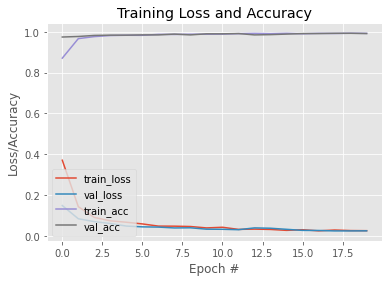

In [ ]:
# plot the training loss and accuracy

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
